# Final Project: 

## Preprocessing the US_Crime_Data.csv

In [2]:
import re
import csv
import calendar
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


good_data, bad_data = [], []

def is_missing(x):
    return x is None or x.strip() == "" or pd.isna(x)

with open("US_Crime_Data.csv", mode="r", encoding="utf-8") as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  

    for row in csv_reader:
        if not row or len(row) < 8:
            bad_data.append(row)
            continue

        date, title, organization, city, state, url, keyword, summary = row

        bad = False

        # check for empty or missing
        if any(is_missing(x) for x in row[:8]):
            bad = True
        else:
            # validate date
            date_val = pd.to_datetime(date, errors='coerce')
            if pd.isna(date_val):
                bad = True

        if len(state.strip()) != 2:
            bad = True

        if bad:
            bad_data.append(row)
        else:
            good_data.append(row)

columns = ["date","title","organization","city","state","url","keyword","summary"]

good_df = pd.DataFrame(good_data, columns=columns)
bad_df = pd.DataFrame(bad_data, columns=columns)

good_df.to_csv("good_data.csv", index=False)
bad_df.to_csv("bad_data.csv", index=False)

## [Question1]: Can we build a predictive model (Decision Tree) to predict whether a hate-crime-related article will mention violence, vandalism, or threats based on its text features 


Incident Type Distribution:
incident_type
other        2415
violence      414
vandalism     175
threat        114
Name: count, dtype: int64

Classification dataset size: (703, 78)
Classes for classification: {'violence': 414, 'vandalism': 175, 'threat': 114}

Decision Tree Accuracy: 0.602

Classification Report:
              precision    recall  f1-score   support

      threat       0.23      0.09      0.13        34
   vandalism       0.75      0.11      0.20        53
    violence       0.62      0.95      0.75       124

    accuracy                           0.60       211
   macro avg       0.53      0.38      0.36       211
weighted avg       0.59      0.60      0.51       211



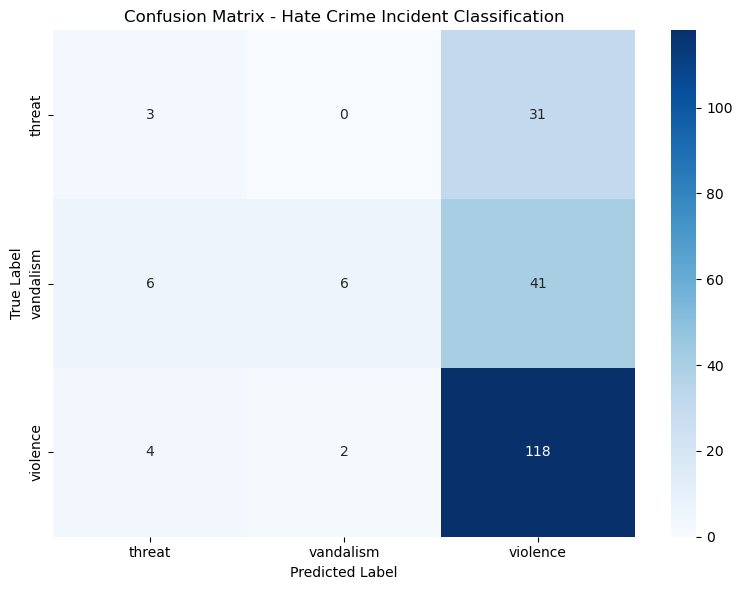

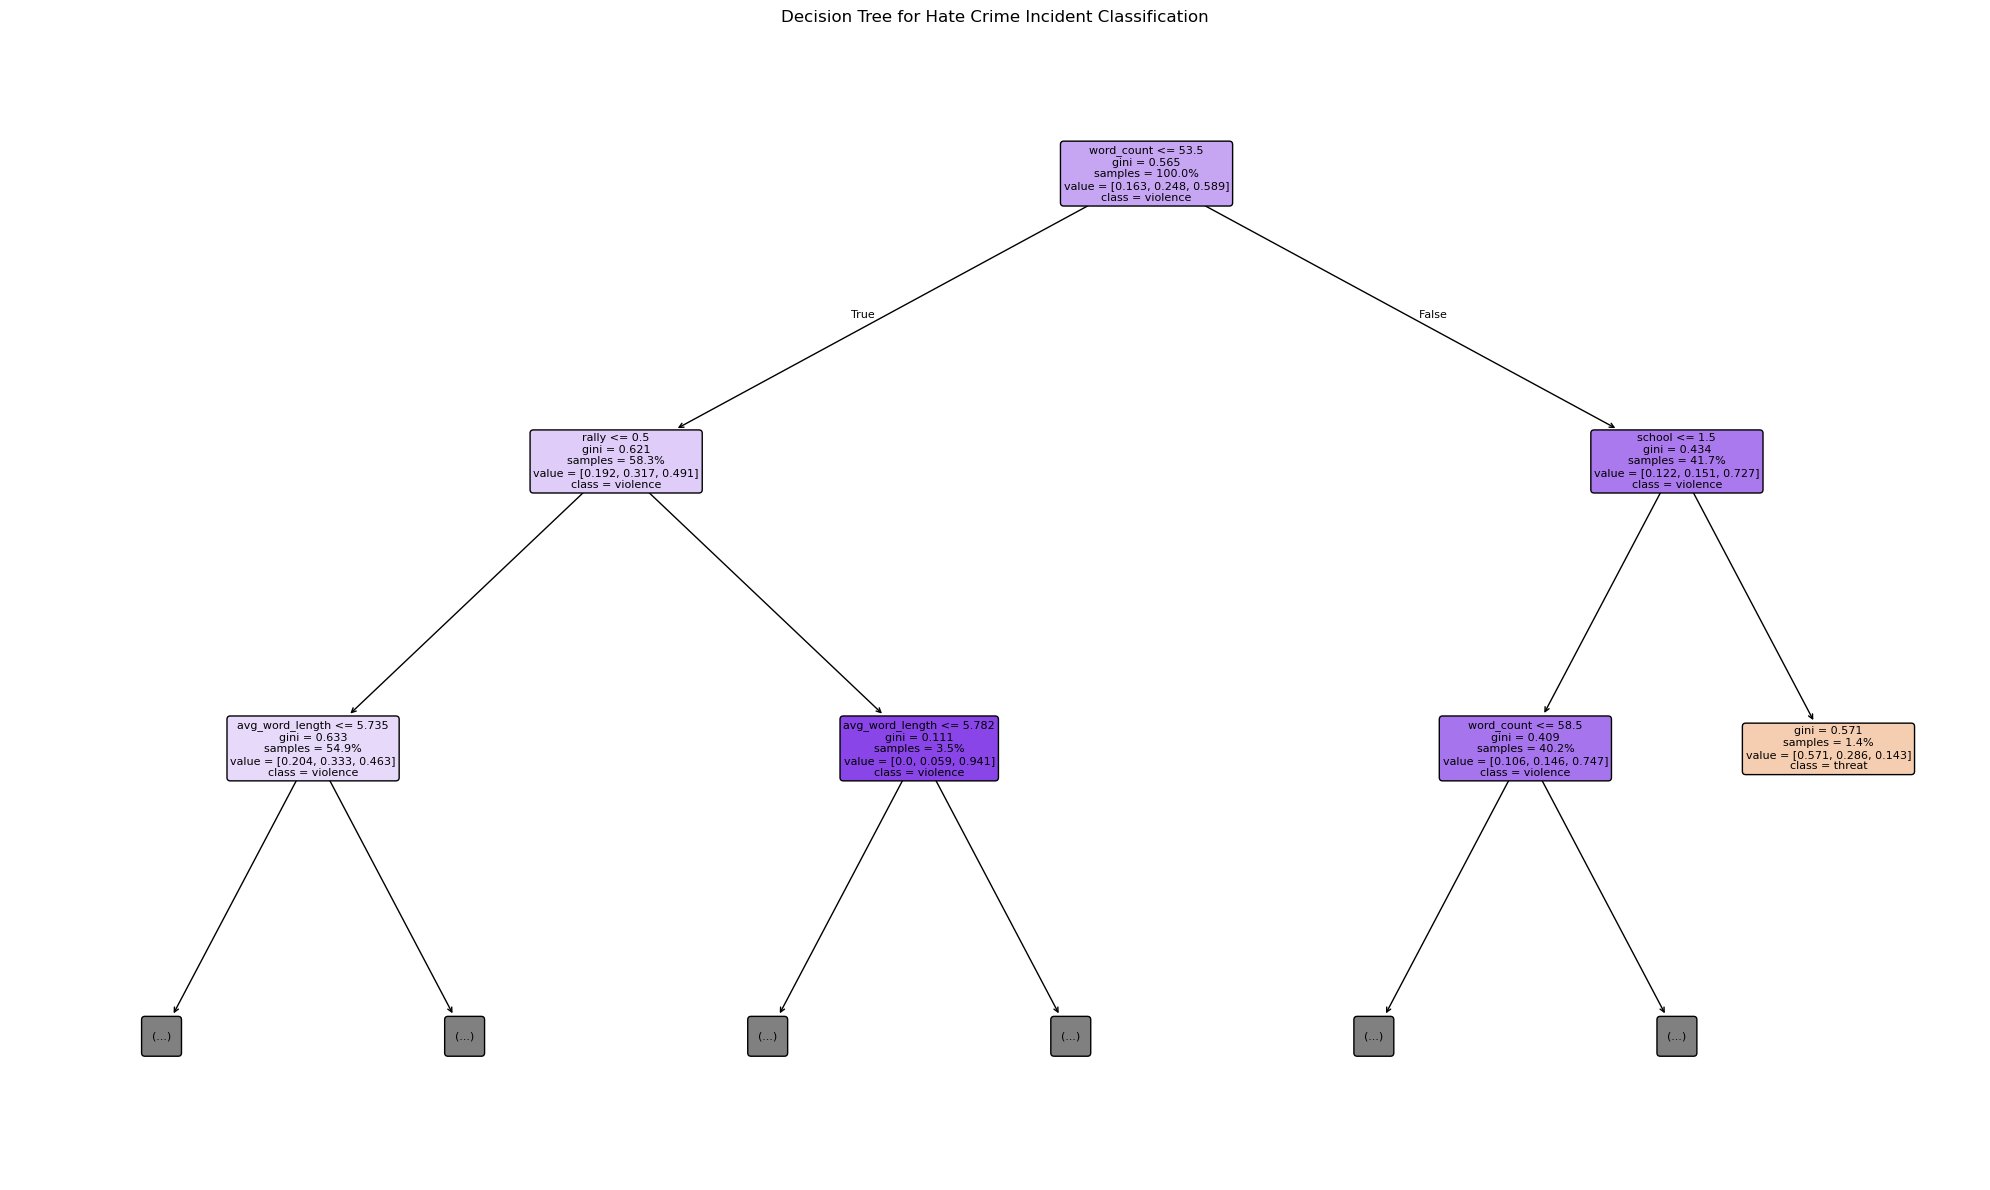


Top 5 Most Important Features:
            feature  importance
74       word_count    0.306396
73      text_length    0.172076
72            rally    0.124306
75  avg_word_length    0.114599
54           school    0.091480


In [7]:
def categorize_incident_type(text):
    """
    Categorize incidents based on keywords in the text 
    """
    if pd.isna(text):
        return 'other'
    
    text = str(text).lower()
    
    # Violence related keywords 
    violence_keywords = ['shot', 'kill', 'murder', 'attack', 'assault', 'beating', 'stab', 
                        'shoot', 'violent', 'assaulted', 'beaten', 'hit', 'punch',
                        'shotgun', 'fatal', 'deadly', 'shooting', 'stabbed', 'homicide']
    
    # Vandalism related keywords
    vandalism_keywords = ['vandal', 'graffiti', 'spray paint', 'damage', 'deface', 'destroy',
                         'property', 'cemetery', 'headstone', 'swastika', 'spray-paint',
                         'vandalized', 'vandalism', 'toppled', 'desecrate', 'tagging']
    
    # Threat related keywords
    threat_keywords = ['threat', 'bomb', 'intimidate', 'harass', 'menace', 'coerce', 'extort',
                      'threats', 'bombing', 'intimidation', 'threatened', 'threatening']
    
    # Count occurrences with stronger requirements
    violence_count = sum(1 for word in violence_keywords if word in text)
    vandalism_count = sum(1 for word in vandalism_keywords if word in text)
    threat_count = sum(1 for word in threat_keywords if word in text)
    
    counts = {'violence': violence_count, 'vandalism': vandalism_count, 'threat': threat_count}
    max_type = max(counts, key=counts.get)
    
    # Stronger classification threshold 
    if counts[max_type] >= 2:   
        return max_type
    else:
        return 'other'

# Apply categorization to the good data
good_df['incident_type'] = good_df['summary'].apply(categorize_incident_type)

print("\nIncident Type Distribution:")
print(good_df['incident_type'].value_counts())

# Prepare features for modeling  
def prepare_features(df):
    """Prepare text features for classification """
    
    # Combine title and summary for better feature extraction
    df['combined_text'] = df['title'] + ' ' + df['summary'].fillna('')
    
    # Define Different Feature Words Not Used In Labeling 
    feature_words = [
        # Contextual violence indicators
        'armed', 'weapon', 'gun', 'knife', 'physical', 'injured', 'hospital',
        'bleeding', 'wound', 'emergency', 'paramedic', 'ambulance',
        
        # Contextual vandalism indicators  
        'building', 'vehicle', 'public', 'wall', 'fence', 'structure',
        'broken', 'smashed', 'shattered', 'broken', 'repair', 'cost',
        
        # Contextual threat indicators
        'message', 'letter', 'phone', 'online', 'social media', 'email',
        'warning', 'danger', 'safe', 'security', 'alert',
        
        # General crime context
        'police', 'investigation', 'arrest', 'charged', 'suspect', 'witness',
        'officer', 'detective', 'crime', 'criminal', 'illegal',
        
        # Location and community context
        'community', 'neighborhood', 'city', 'street', 'area', 'local',
        'resident', 'business', 'school', 'park', 'home',
        
        # Temporal context
        'night', 'morning', 'afternoon', 'evening', 'weekend', 'today',
        
        # Emotional/impact context
        'fear', 'scared', 'terror', 'angry', 'outrage', 'response',
        'condemn', 'denounce', 'protest', 'rally'
    ]
    
    # Create feature matrix
    features = []
    for text in df['combined_text']:
        text_lower = str(text).lower()
        feature_vector = [text_lower.count(word) for word in feature_words]
        
        words = text_lower.split()
        feature_vector.extend([
            len(text),                     
            len(words),                   
            sum(len(word) for word in words) / max(len(words), 1),   
            text_lower.count('!'),       
            text_lower.count('?'),         
        ])
        
        features.append(feature_vector)
    
    # Combine all feature names
    feature_names = feature_words + ['text_length', 'word_count', 'avg_word_length', 'exclamation_marks', 'question_marks']
    feature_df = pd.DataFrame(features, columns=feature_names)
    return feature_df

# Prepare features and target
feature_df = prepare_features(good_df)
X = feature_df
y = good_df['incident_type']

# Filter to only include the three main categories for classification
classification_mask = y.isin(['violence', 'vandalism', 'threat'])
X_class = X[classification_mask]
y_class = y[classification_mask]

print(f"\nClassification dataset size: {X_class.shape}")
print(f"Classes for classification: {y_class.value_counts().to_dict()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_class, y_class, test_size=0.3, random_state=42, stratify=y_class
)

# Train Decision Tree model
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5,random_state=42
)

dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nDecision Tree Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# *** Plot The Confusion Matrix ***
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.title('Confusion Matrix - Hate Crime Incident Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


# *** Visualize The Decision Tree ***
plt.figure(figsize=(20, 12))
plot_tree(dt_model, feature_names=X.columns, class_names=dt_model.classes_, filled=True, rounded=True, fontsize=8, proportion=True, max_depth=2)  
plt.title('Decision Tree for Hate Crime Incident Classification')
plt.tight_layout()
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head(5))



## [Question2]: How does hate crime reporting intensity and geographic focus change across different seasons and years?  

*** Data Overview ***:
Total articles: 3118
Date range: 2017-03-24 11:11:00 to 2017-12-18 19:56:00
States covered: 58
Years in dataset: [np.int32(2017)] (1 years)


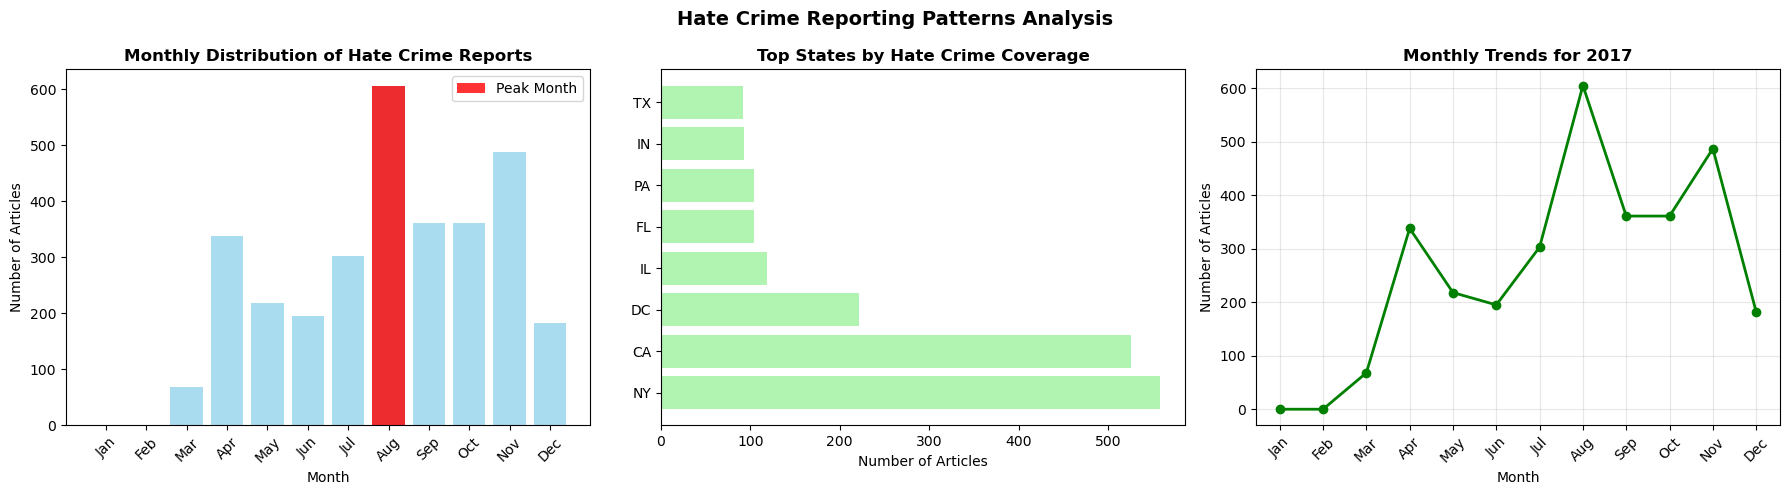

In [31]:
columns = ["date","title","organization","city","state","url","keyword","summary"]
good_df = pd.DataFrame(good_data, columns=columns)

# Convert and clean dates
good_df['date'] = pd.to_datetime(good_df['date'], format='mixed', errors='coerce')
good_df = good_df.dropna(subset=['date'])

print(f"*** Data Overview ***:")
print(f"Total articles: {len(good_df)}")
print(f"Date range: {good_df['date'].min()} to {good_df['date'].max()}")
print(f"States covered: {good_df['state'].nunique()}")

# Extract  features
good_df['year'] = good_df['date'].dt.year
good_df['month'] = good_df['date'].dt.month
good_df['year_month'] = good_df['date'].dt.to_period('M')

years = sorted(good_df['year'].unique())
print(f"Years in dataset: {years} ({len(years)} years)")

# Create the 3-graph visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Hate Crime Reporting Patterns Analysis', fontsize=14, fontweight='bold')

# GRAPH 1: Monthly Distribution  
monthly_counts = good_df['month'].value_counts().sort_index()
# Fill missing months with 0
all_months = range(1, 13)
month_data = [monthly_counts.get(month, 0) for month in all_months]
month_names = [calendar.month_abbr[i] for i in all_months]

axes[0].bar(month_names, month_data, color='skyblue', alpha=0.7)
axes[0].set_title('Monthly Distribution of Hate Crime Reports', fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Articles')
axes[0].tick_params(axis='x', rotation=45)

# Highlight the peak month
peak_month_idx = np.argmax(month_data)
axes[0].bar(month_names[peak_month_idx], month_data[peak_month_idx], 
           color='red', alpha=0.8, label='Peak Month')
axes[0].legend()

# GRAPH 2: Geographic Distribution by State
state_counts = good_df['state'].value_counts().head(8)   

if len(state_counts) > 0:
    axes[1].barh(range(len(state_counts)), state_counts.values, color='lightgreen', alpha=0.7)
    axes[1].set_yticks(range(len(state_counts)))
    axes[1].set_yticklabels(state_counts.index)
    axes[1].set_title('Top States by Hate Crime Coverage', fontweight='bold')
    axes[1].set_xlabel('Number of Articles')
else:
    axes[1].text(0.5, 0.5, 'No state data available', 
                horizontalalignment='center', verticalalignment='center',
                transform=axes[1].transAxes, fontsize=12)
    axes[1].set_title('State Distribution: No Data', fontweight='bold')

# GRAPH 3: Time-based analysis  
if len(years) > 1:
    # Multiple years  
    annual_trends = good_df.groupby('year').agg({
        'title': 'count',
        'state': 'nunique'
    }).rename(columns={'title': 'articles', 'state': 'states'})
    
    x_pos = np.arange(len(annual_trends))
    width = 0.35
    
    bars1 = axes[2].bar(x_pos - width/2, annual_trends['articles'], width, 
                       label='Articles', alpha=0.7)
    bars2 = axes[2].bar(x_pos + width/2, annual_trends['states'], width, 
                       label='States Covered', alpha=0.7)
    
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Count')
    axes[2].set_title('Annual Trends: Articles vs Geographic Coverage', fontweight='bold')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(annual_trends.index)
    axes[2].legend()
    axes[2].tick_params(axis='x', rotation=45)
    
elif len(years) == 1:
    # Single year - show monthly trends for that year
    year_data = good_df[good_df['year'] == years[0]]
    monthly_year = year_data.groupby('month').size()
    monthly_data = [monthly_year.get(month, 0) for month in all_months]
    
    axes[2].plot(month_names, monthly_data, 'go-', linewidth=2, markersize=6)
    axes[2].set_xlabel('Month')
    axes[2].set_ylabel('Number of Articles')
    axes[2].set_title(f'Monthly Trends for {years[0]}', fontweight='bold')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## [Question3]: Can news articles be grouped into meaningful clusters based on their keywords and summaries (Using K-Means)
 

Number of articles for clustering: 3118
TF-IDF matrix shape: (3118, 1000)
Explained variance ratio: [0.01605678 0.01285088]
Silhouette Score for k=4: 0.014


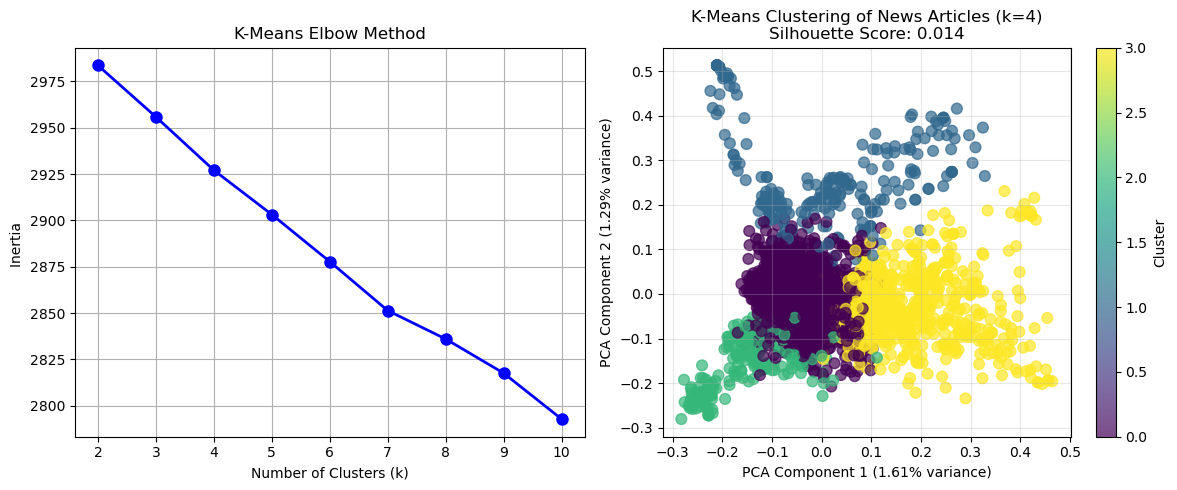


Cluster Statistics
Total articles clustered: 3118
Number of clusters: 4
Average silhouette score: 0.014
Cluster 0: 2004 articles (64.3%)
Cluster 1: 243 articles (7.8%)
Cluster 2: 191 articles (6.1%)
Cluster 3: 680 articles (21.8%)
Elbow Analysis:
k	Inertia		Difference	% Drop
----------------------------------------
2	2984		N/A		N/A
3	2956		28		0.9%
4	2927		29		1.0%
5	2903		24		0.8%
6	2878		25		0.9%
7	2851		26		0.9%
8	2836		15		0.5%
9	2818		18		0.6%
10	2793		25		0.9%

Selected k = 4 (based on elbow point analysis)


In [16]:
# Load the preprocessed data
df = pd.read_csv("good_data.csv")

# Data Preparation for Clustering

# Combine keywords and summaries for text analysis
df['text_content'] = df['keyword'].fillna('') + " " + df['summary'].fillna('')

# Clean text data
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

df['cleaned_text'] = df['text_content'].apply(clean_text)

# Remove empty or very short texts
df = df[df['cleaned_text'].str.len() > 10]

print(f"Number of articles for clustering: {len(df)}")


# Feature Extraction using TF-IDF

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,   
    min_df=2,           
    max_df=0.8,        
    stop_words='english',
    ngram_range=(1, 2)  
)

# Transform text to TF-IDF features
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Dimensionality Reduction with PCA for visualization

# Convert sparse matrix to dense for PCA
tfidf_dense = tfidf_matrix.toarray()

# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
pca_features = pca.fit_transform(tfidf_dense)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")


# Elbow Method for Optimal Cluster Selection

inertia = []
K = range(2, 11)  

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(tfidf_matrix)
    inertia.append(km.inertia_)

plt.figure(figsize=(12, 5))

# Plot Elbow Method
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia ')
plt.title("K-Means Elbow Method")
plt.grid(True)

# Fit K-means with found  k  
k = 4  # Found by finding the largest difference between numbers which is 4 in the elbow method
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(tfidf_matrix)

df['cluster'] = clusters

# Calculate silhouette score
silhouette_avg = silhouette_score(tfidf_matrix, clusters)
print(f"Silhouette Score for k={k}: {silhouette_avg:.3f}")


# Visualize clusters using PCA to reduce features
plt.subplot(1, 2, 2)
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=df['cluster'], cmap='viridis', s=60, alpha=0.7)

plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title(f'K-Means Clustering of News Articles (k={k})\nSilhouette Score: {silhouette_avg:.3f}')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# -----------------------------
# Print cluster statistics
# -----------------------------

print("\n===========================")
print("Cluster Statistics")
print("===========================")
print(f"Total articles clustered: {len(df)}")
print(f"Number of clusters: {k}")
print(f"Average silhouette score: {silhouette_avg:.3f}")

cluster_sizes = df['cluster'].value_counts().sort_index()
for cluster_id, size in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {size} articles ({size/len(df)*100:.1f}%)")


# Simple calculation showing differences
print("Elbow Analysis:")
print("k\tInertia\t\tDifference\t% Drop")
print("-" * 40)

for i in range(len(inertia)):
    k_val = K[i]
    inertia_val = inertia[i]
    
    if i == 0:
        diff = "N/A"
        pct_drop = "N/A"
    else:
        diff = inertia[i-1] - inertia_val
        pct_drop = f"{((inertia[i-1] - inertia_val) / inertia[i-1] * 100):.1f}%"
    
    print(f"{k_val}\t{inertia_val:.0f}\t\t{diff if isinstance(diff, str) else f'{diff:.0f}'}\t\t{pct_drop}")

print(f"\nSelected k = 4 (based on elbow point analysis)")

# Final Project: Katelyne Wildermuth

## [Question 4]: What is the distribution of hate-crime reporting during the peak month?

*** Data Overview ***:
Total articles: 3118
Date range: 2017-08-01 to 2017-08-31
States covered: 58
Years in dataset: [np.int32(2017)] (1 years)

STRATEGIC RECOMMENDATION:
   Focus awareness campaigns in the second and third weeks of August during peak reporting periods

DATA QUALITY NOTE: 3118 articles analyzed from 1 year(s)


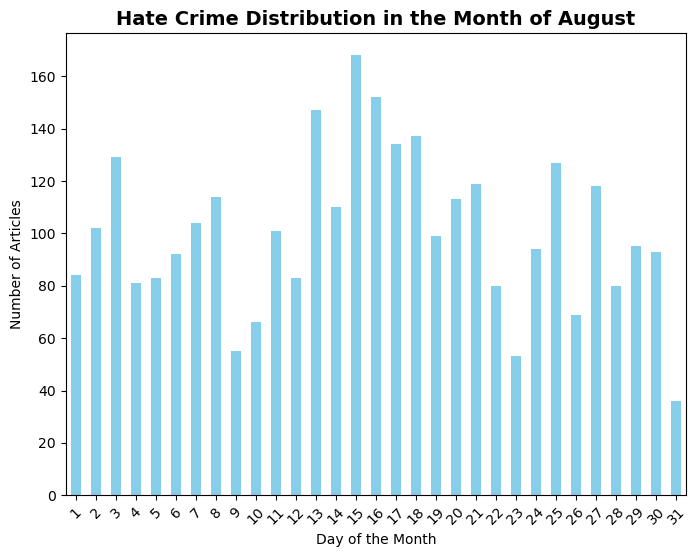

In [21]:
#[Question 4]: What is the distribution of hate-crime reporting during the peak month?
columns = ["date","title","organization","city","state","url","keyword","summary"]
good_df = pd.DataFrame(good_data, columns=columns)

# Convert and clean dates
good_df['date'] = pd.to_datetime(good_df['date'], format='mixed', errors='coerce')
good_df = good_df.dropna(subset=['date'])

# Select dates for peak month (August 1st to August 31st)
start_date = '2017-08-01'
end_date = '2017-08-31'

print(f"*** Data Overview ***:")
print(f"Total articles: {len(good_df)}")
print(f"Date range: {start_date} to {end_date}")
print(f"States covered: {good_df['state'].nunique()}")

# Extract  features
good_df['year'] = good_df['date'].dt.year
good_df['day'] = good_df['date'].dt.day
good_df['year_month'] = good_df['date'].dt.to_period('M')

years = sorted(good_df['year'].unique())
print(f"Years in dataset: {years} ({len(years)} years)")

# Create the graph visualization
plt.figure(figsize=(8, 6))
plt.title('Hate Crime Distribution in the Month of August', fontsize=14, fontweight='bold')

daily_counts = good_df['day'].value_counts().sort_index()

daily_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Articles')
plt.tick_params(axis='x', rotation=45)

# Strategic recommendations
print(f"\nSTRATEGIC RECOMMENDATION:")
print(f"   Focus awareness campaigns in the second and third weeks of August during peak reporting periods")
print(f"\nDATA QUALITY NOTE: {len(good_df)} articles analyzed from {len(years)} year(s)")